#                       PUC MG - Pontificia Católica de Minas Gerais
##                  Pós-graduação Lato Sensu em Ciência de Dados e Big Data

                            TRABALHO DE CONCLUSÃO DE CURSO

TÍTULO : UTILIZANDO MACHINE LEARNING PARA PREVER O PREÇO DE UM ATIVO DE RENDA VARIÁVEL NA BOLSA DE VALORES

ALUNA : Rosana de Paula Coutinho Barros

Entrega: Fevereiro de 2022

## Importação das Bibliotecas Python


In [ ]:
import pandas as pd
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

import math 
import numpy as np
from  keras.models import Sequential 
from keras.layers import Dense, LSTM 

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict


%matplotlib inline


In [ ]:
#Importando dados do csv
df_bb = pd.read_csv("Series_acao_BBAS3_2009_2021.csv", delimiter=';', encoding='latin-1') 
df_bb

,data_pregao,sigla_acao,nome_acao,preco_abertura,preco_maximo,preco_minimo,preco_medio,preco_fechamento,qtd_negocios,volume_negocios
0,2009-01-02,BBAS3,BRASIL ON NM,6.449707,6.772378,6.326971,6.569094,6.580084,2869400,42991378
1,2009-01-05,BBAS3,BRASIL ON NM,6.590300,6.927809,6.357306,6.648028,6.702912,5339200,80961624
2,2009-01-06,BBAS3,BRASIL ON NM,6.801190,7.207586,6.578317,6.897987,7.071397,4080100,64215643
3,2009-01-07,BBAS3,BRASIL ON NM,6.981325,7.083241,6.695322,6.862905,6.913475,1831200,28678803
4,2009-01-08,BBAS3,BRASIL ON NM,6.823158,6.967778,6.530648,6.718192,6.755553,6465700,99102752
...,...,...,...,...,...,...,...,...,...,...
3209,2021-12-23,BBAS3,BRASIL ON NM,29.300000,29.480000,29.160000,29.260000,29.220000,7337800,214724088
3210,2021-12-27,BBAS3,BRASIL ON NM,29.250000,29.490000,29.200000,29.300000,29.280000,5746200,168380059
3211,2021-12-28,BBAS3,BRASIL ON NM,29.340000,29.390000,29.010000,29.110000,29.110000,8640700,251594596
3212,2021-12-29,BBAS3,BRASIL ON NM,29.180000,29.310000,28.940000,29.060000,28.960000,7666400,222837856


## Pré-Processamento dos dados

In [ ]:
#verificar os tipos contidos no datafame
df_bb.dtypes

data_pregao          object
sigla_acao           object
nome_acao            object
preco_abertura      float64
preco_maximo        float64
preco_minimo        float64
preco_medio         float64
preco_fechamento    float64
qtd_negocios          int64
volume_negocios       int64
dtype: object

In [ ]:
#altera o tipo do dado 
df_bb['data_pregao']=pd.to_datetime(df_bb['data_pregao'], format='%Y-%m-%d')

In [ ]:
df_bb.dtypes

data_pregao         datetime64[ns]
sigla_acao                  object
nome_acao                   object
preco_abertura             float64
preco_maximo               float64
preco_minimo               float64
preco_medio                float64
preco_fechamento           float64
qtd_negocios                 int64
volume_negocios              int64
dtype: object

In [ ]:
 #criando novas colunas paras medias móveis
df_bb['mm5d']=df_bb['preco_fechamento'].rolling(5).mean()                       #media movel dos ultimos 5 dias
df_bb['mm21d']=df_bb['preco_fechamento'].rolling(21).mean()                     #media movel dos ultimos 21 dias

In [ ]:
df_bb.head()

,data_pregao,sigla_acao,nome_acao,preco_abertura,preco_maximo,preco_minimo,preco_medio,preco_fechamento,qtd_negocios,volume_negocios,mm5d,mm21d
0,2009-01-02,BBAS3,BRASIL ON NM,6.449707,6.772378,6.326971,6.569094,6.580084,2869400,42991378,NaN,NaN
1,2009-01-05,BBAS3,BRASIL ON NM,6.590300,6.927809,6.357306,6.648028,6.702912,5339200,80961624,NaN,NaN
2,2009-01-06,BBAS3,BRASIL ON NM,6.801190,7.207586,6.578317,6.897987,7.071397,4080100,64215643,NaN,NaN
3,2009-01-07,BBAS3,BRASIL ON NM,6.981325,7.083241,6.695322,6.862905,6.913475,1831200,28678803,NaN,NaN
4,2009-01-08,BBAS3,BRASIL ON NM,6.823158,6.967778,6.530648,6.718192,6.755553,6465700,99102752,6.804684,NaN


In [ ]:
#Empurrando para frente os valores de preco de fechamento
df_bb['preco_fechamento'] = df_bb['preco_fechamento'].shift(-1)
df_bb.head()

,data_pregao,sigla_acao,nome_acao,preco_abertura,preco_maximo,preco_minimo,preco_medio,preco_fechamento,qtd_negocios,volume_negocios,mm5d,mm21d
0,2009-01-02,BBAS3,BRASIL ON NM,6.449707,6.772378,6.326971,6.569094,6.702912,2869400,42991378,NaN,NaN
1,2009-01-05,BBAS3,BRASIL ON NM,6.590300,6.927809,6.357306,6.648028,7.071397,5339200,80961624,NaN,NaN
2,2009-01-06,BBAS3,BRASIL ON NM,6.801190,7.207586,6.578317,6.897987,6.913475,4080100,64215643,NaN,NaN
3,2009-01-07,BBAS3,BRASIL ON NM,6.981325,7.083241,6.695322,6.862905,6.755553,1831200,28678803,NaN,NaN
4,2009-01-08,BBAS3,BRASIL ON NM,6.823158,6.967778,6.530648,6.718192,6.966116,6465700,99102752,6.804684,NaN


In [ ]:

df_bb.isnull().sum()

data_pregao          0
sigla_acao           0
nome_acao            0
preco_abertura       0
preco_maximo         0
preco_minimo         0
preco_medio          0
preco_fechamento     1
qtd_negocios         0
volume_negocios      0
mm5d                 4
mm21d               20
dtype: int64

In [ ]:
#retirando os dados nulos
df_bb.dropna(inplace=True)

In [ ]:

df_bb.isnull().sum()

data_pregao         0
sigla_acao          0
nome_acao           0
preco_abertura      0
preco_maximo        0
preco_minimo        0
preco_medio         0
preco_fechamento    0
qtd_negocios        0
volume_negocios     0
mm5d                0
mm21d               0
dtype: int64

In [ ]:
#reindexando o data frame
df_bb = df_bb.reset_index(drop=True)
df_bb

,data_pregao,sigla_acao,nome_acao,preco_abertura,preco_maximo,preco_minimo,preco_medio,preco_fechamento,qtd_negocios,volume_negocios,mm5d,mm21d
0,2009-01-30,BBAS3,BRASIL ON NM,6.203669,6.372696,6.088626,6.227045,6.036130,2523800,35851049,6.274768,6.430518
1,2009-02-02,BBAS3,BRASIL ON NM,6.107012,6.261674,5.954287,6.095487,6.220373,2733000,37994527,6.244061,6.404615
2,2009-02-03,BBAS3,BRASIL ON NM,6.107012,6.381578,5.984621,6.183192,6.123865,2827500,39897234,6.229146,6.381637
3,2009-02-04,BBAS3,BRASIL ON NM,6.260785,6.461515,6.023623,6.240200,6.316881,4734100,67356685,6.163345,6.336516
4,2009-02-05,BBAS3,BRASIL ON NM,6.133373,6.425987,6.027957,6.235815,6.395842,3308800,47067643,6.185279,6.308107
...,...,...,...,...,...,...,...,...,...,...,...,...
3188,2021-12-22,BBAS3,BRASIL ON NM,29.600000,29.650000,29.160000,29.280000,29.220000,12478200,365442015,29.998000,31.306042
3189,2021-12-23,BBAS3,BRASIL ON NM,29.300000,29.480000,29.160000,29.260000,29.280000,7337800,214724088,29.560000,31.265289
3190,2021-12-27,BBAS3,BRASIL ON NM,29.250000,29.490000,29.200000,29.300000,29.110000,5746200,168380059,29.350000,31.153038
3191,2021-12-28,BBAS3,BRASIL ON NM,29.340000,29.390000,29.010000,29.110000,28.960000,8640700,251594596,29.288000,31.082419


## Análise Exploratória dos Dados

In [ ]:
df_bb.describe()

,preco_abertura,preco_maximo,preco_minimo,preco_medio,preco_fechamento,qtd_negocios,volume_negocios,mm5d,mm21d
count,3193.000000,3193.000000,3193.000000,3193.000000,3193.000000,3.193000e+03,3.193000e+03,3193.000000,3193.000000
mean,21.234302,21.634900,20.798414,21.208826,21.211728,9.104226e+06,2.792241e+08,21.190364,21.129381
std,9.914085,10.012318,9.789881,9.897378,9.890505,6.367690e+06,2.319908e+08,9.884825,9.855214
min,5.953678,6.141769,5.761373,5.935908,5.876552,7.398000e+05,1.594301e+07,6.020998,6.138929
25%,13.865079,14.185712,13.526916,13.865674,13.867650,4.973000e+06,1.217496e+08,13.826098,13.868892
50%,16.501579,16.837974,16.108878,16.459292,16.512123,7.519500e+06,1.932484e+08,16.419869,16.370909
75%,28.264359,28.702408,27.809916,28.267384,28.220185,1.127470e+07,3.777128e+08,28.270267,28.331762
max,48.349122,48.525043,47.562247,47.883927,48.000589,1.020361e+08,2.964447e+09,47.588421,46.296431


In [ ]:
#seleciona um periodo menor para zoom na vizualizacao do grafico de histoprico de precos
df_bb_2017_2021 = df_bb.loc[df_bb['data_pregao'] >= '2017-01-01']
df_bb_2017_2021.set_index('data_pregao', inplace=True)

In [ ]:
#Criando um dataFrame cujo o index seja a propria data para a plotagem do grafico de historico
df_grafico = df_bb.copy()
df_grafico.set_index('data_pregao', inplace=True)

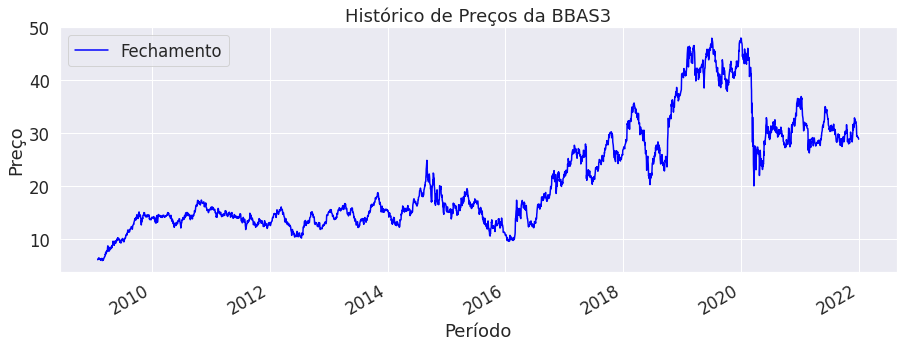

In [ ]:
#Plotagem da serie historica de todo o periodo 
plt.figure(figsize=(15,5))
#df_grafico['preco_maximo'].plot(label='Maximo', color='green')
#df_grafico['preco_minimo'].plot(label='Minimo', color='red')
df_grafico['preco_fechamento'].plot(label='Fechamento', color='blue')
plt.ylabel('Preço')
plt.xlabel('Período')
plt.title('Histórico de Preços da BBAS3')
plt.legend();

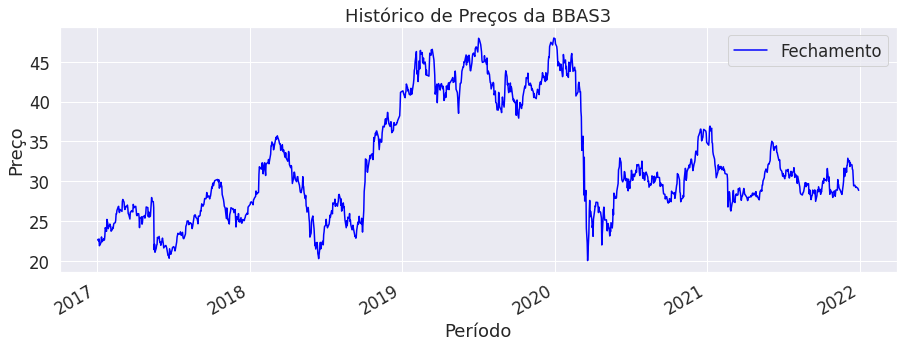

In [ ]:
#Plotagem da serie historica a partir de 2017
plt.figure(figsize=(15,5))
#df_bb_2017_2021['preco_maximo'].plot(label='Maximo', color='green')
#df_bb_2017_2021['preco_minimo'].plot(label='Minimo', color='red')
df_bb_2017_2021['preco_fechamento'].plot(label='Fechamento', color='blue')
plt.ylabel('Preço')
plt.xlabel('Período')
plt.title('Histórico de Preços da BBAS3')
plt.legend();

Text(0.5, 1.0, 'Variacao de Preços diario da BBAS3')

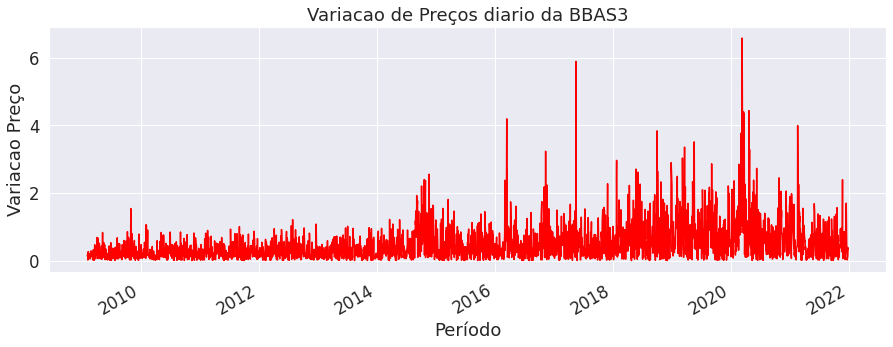

In [ ]:
#Plotagem da variacao de preco 
variacao_bbas3 = abs(df_grafico['preco_abertura'] - df_grafico['preco_fechamento'])
plt.figure(figsize=(15,5))
variacao_bbas3.plot(label='Variacao de Preço', color='red')
plt.ylabel('Variacao Preço')
plt.xlabel('Período')
plt.title('Variacao de Preços diario da BBAS3')

In [ ]:
#Retorna a data com a maior variacao entre o preco de abertura e fechamento
maxima_variacao_bbas3 = variacao_bbas3.values.argmax()
maximo_valor_bbas3 = variacao_bbas3.values[maxima_variacao_bbas3,]
variacao_bbas3[variacao_bbas3.values==maximo_valor_bbas3]

data_pregao
2020-03-12    6.589182
dtype: float64

Text(0.5, 1.0, 'Volume negociado da BBAS3')

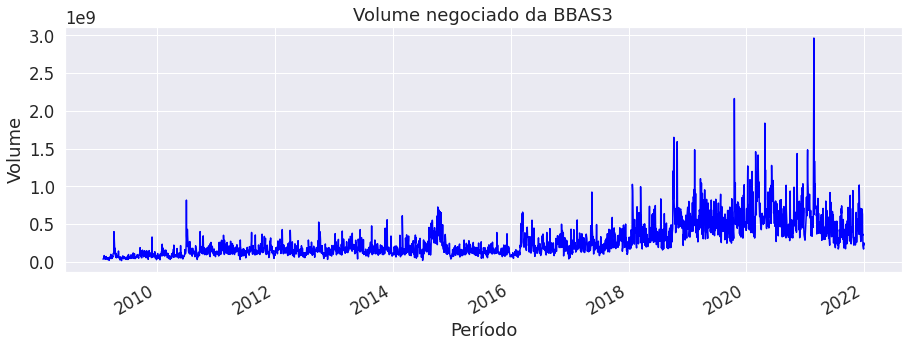

In [ ]:
#Plotagem do volume negociado no periodo 
plt.figure(figsize=(15,5))
df_grafico['volume_negocios'].plot(label='Volume', color='blue')
plt.ylabel('Volume')
plt.xlabel('Período')
plt.title('Volume negociado da BBAS3')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribuicao do preco de fechamento da BBAS3')

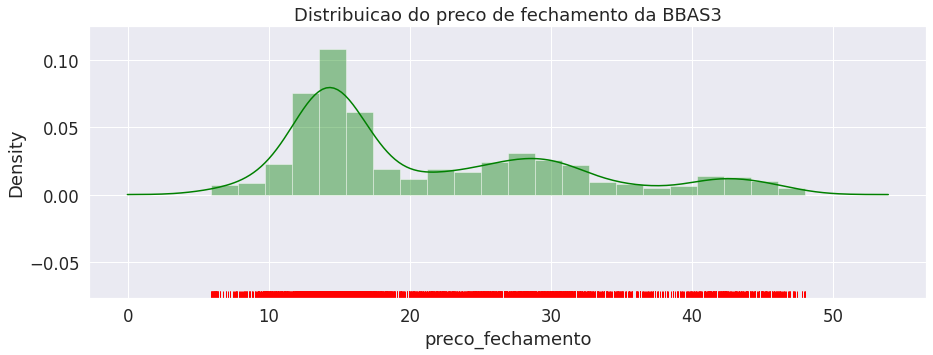

In [ ]:
#Plota um histograma da distribuicao da BBAS3 utilizando precos de fechamento do dia
plt.figure(figsize=(15,5))

sns.set_context('notebook', font_scale=1.5, rc={ 'font.size' : 20, 'axes.labesize':18 } )
sns.rugplot(df_grafico['preco_fechamento'], color='red')
sns.distplot(df_grafico['preco_fechamento'], color='green')
sns.set_style('darkgrid')
plt.title('Distribuicao do preco de fechamento da BBAS3')

In [ ]:
#Retorna a data com maior volume de negociacao
maxima_volume_negociacao = df_grafico['volume_negocios'].argmax()
df_grafico.iloc[maxima_volume_negociacao,:]

sigla_acao                 BBAS3
nome_acao           BRASIL ON NM
preco_abertura           27.3949
preco_maximo             27.7495
preco_minimo             26.4913
preco_medio              26.9683
preco_fechamento         28.6771
qtd_negocios           102036096
volume_negocios       2964447352
mm5d                     30.0406
mm21d                    31.1922
Name: 2021-02-22 00:00:00, dtype: object

## Escolha das Melhores Features e Normalização os dados
 

In [ ]:
#Definindo a quantidade de linhas para cada utilizacao

qtd_linhas = len(df_bb)

qtd_linhas_treino= round(.70 * qtd_linhas)
qtd_linhas_teste= round(.28 * qtd_linhas)
qtd_linhas_validacao = round(.02 * qtd_linhas)

info = (
    f"linhas treino= 0:{qtd_linhas_treino}"
    f" linhas teste= {qtd_linhas_treino}:{qtd_linhas_treino + qtd_linhas_teste -1}"
    f" linhas validação= {qtd_linhas_treino + qtd_linhas_teste}:{qtd_linhas }"
)

info

'linhas treino= 0:2235 linhas teste= 2235:3128 linhas validação= 3129:3193'

In [ ]:
print("quantidade linhas treino {}".format(qtd_linhas_treino))
print("quantidade linhas teste {}".format(qtd_linhas_teste))
print("quantidade linhas validacao {}".format(qtd_linhas_validacao))

quantidade linhas treino 2235
quantidade linhas teste 894
quantidade linhas validacao 64


In [ ]:
#definindo as features e as labels
features = df_bb.drop(['sigla_acao', 'nome_acao', 'data_pregao', 'preco_fechamento'], 1)
labels = df_bb['preco_fechamento']
features

,preco_abertura,preco_maximo,preco_minimo,preco_medio,qtd_negocios,volume_negocios,mm5d,mm21d
0,6.203669,6.372696,6.088626,6.227045,2523800,35851049,6.274768,6.430518
1,6.107012,6.261674,5.954287,6.095487,2733000,37994527,6.244061,6.404615
2,6.107012,6.381578,5.984621,6.183192,2827500,39897234,6.229146,6.381637
3,6.260785,6.461515,6.023623,6.240200,4734100,67356685,6.163345,6.336516
4,6.133373,6.425987,6.027957,6.235815,3308800,47067643,6.185279,6.308107
...,...,...,...,...,...,...,...,...
3188,29.600000,29.650000,29.160000,29.280000,12478200,365442015,29.998000,31.306042
3189,29.300000,29.480000,29.160000,29.260000,7337800,214724088,29.560000,31.265289
3190,29.250000,29.490000,29.200000,29.300000,5746200,168380059,29.350000,31.153038
3191,29.340000,29.390000,29.010000,29.110000,8640700,251594596,29.288000,31.082419


In [ ]:
#Escolhendo as melhores features com SelectKBest
features_list = ('preco_abertura','preco_max','preco_minimo','qtd_negocios','volume_negocios','mm5d','mm21d')

k_best_features = SelectKBest(k='all')
k_best_features.fit_transform(features, labels)
k_best_features_scores = k_best_features.scores_
raw_pairs = zip(features_list[1:], k_best_features_scores)
ordered_pairs = list(reversed(sorted(raw_pairs, key=lambda x: x[1])))

k_best_features_final = dict(ordered_pairs[:15])
best_features = k_best_features_final.keys()
print ('')
print ("Melhores features:")
print (k_best_features_final)


Melhores features:
{'volume_negocios': 570.4145829659857, 'preco_minimo': 540.4077807815858, 'qtd_negocios': 458.98780954377486, 'preco_max': 349.598128585858, 'mm21d': 5.360335926361045, 'mm5d': 3.536955982786019}


In [ ]:
#criando um df com as features selecionadas
features = df_bb.loc[:,['preco_maximo','preco_minimo','volume_negocios','qtd_negocios']]

In [ ]:
#Cria os datasets de treino e teste

x_train = features[:qtd_linhas_treino]
x_test = features[qtd_linhas_treino:qtd_linhas_treino + qtd_linhas_teste -1]

y_train = labels[:qtd_linhas_treino]
y_test = labels[qtd_linhas_treino:qtd_linhas_treino + qtd_linhas_teste -1]

x_validacao = features.tail(64) #2% das linhas do dataset inteiro



In [ ]:
#Normalizando os datasets de treino, teste e validação com MinMaxScaler

scaler = MinMaxScaler()

x_train_scale = scaler.fit_transform(x_train)  
x_test_scale  = scaler.transform(x_test)  
x_validacao_scale = scaler.transform(x_validacao)  

## Modelo de Regressão Linear do SKlearn  (com cross-validation)



In [ ]:
#construcao e treinamento usando regressao linear do SKlearn

lr = linear_model.LinearRegression()   
lr.fit(x_train_scale, y_train)    
pred= lr.predict(x_test_scale)

score_lr = lr.score(x_test_scale,y_test )
print("Score: %.3f%%" % (score_lr * 100.0))


Score: 98.218%


In [ ]:
#executando o modelo Linear para obter as predicoes 
pred=lr.predict(x_validacao_scale)            

In [ ]:
#dados reais X dados previstos pelo modelo
data_pregao_full = df_bb['data_pregao']
data_pregao=data_pregao_full.tail(64)
res_full=df_bb['preco_fechamento']
res=res_full.tail(64)
df_comparativo_lr =pd.DataFrame({'data_pregao':data_pregao, 'real':res, 'previsao':pred})
df_comparativo_lr.set_index('data_pregao', inplace=True)
df_comparativo_lr['distancia']= abs( df_comparativo_lr['real'] - df_comparativo_lr['previsao'] ) 

print(df_comparativo_lr)

                  real   previsao  distancia
data_pregao                                 
2021-09-27   28.704554  29.213963   0.509409
2021-09-28   28.861516  29.101547   0.240031
2021-09-29   28.351388  28.981741   0.630353
2021-09-30   28.989049  28.732888   0.256161
2021-10-01   28.645693  28.705187   0.059494
...                ...        ...        ...
2021-12-22   29.220000  29.472910   0.252910
2021-12-23   29.280000  29.347319   0.067319
2021-12-27   29.110000  29.357003   0.247003
2021-12-28   28.960000  29.235563   0.275563
2021-12-29   28.850000  29.150347   0.300347

[64 rows x 3 columns]


**Validacao Cruzada** 


In [ ]:
#definindo os dados de entreada e saida 

x_entradas = df_bb.loc[:,['preco_maximo','preco_minimo','volume_negocios','qtd_negocios']]
y_target = df_bb.loc[:,['preco_fechamento']]
x = x_entradas.to_numpy()
y = y_target.to_numpy()

In [ ]:
#construcao da maquina preditiva 

num_folds = 4
seed = 7 
kfold = KFold(num_folds, shuffle=True, random_state= seed)

modelo_lr_vc = linear_model.LinearRegression()  

#Treinando a maquina com validacao cruzada 
score_lr_vc = cross_val_score(modelo_lr_vc, x, y, cv = kfold)


print("Score: %.3f%%" % (score_lr_vc.mean() * 100.0))


Score: 99.585%


In [ ]:
#obtendo as predicoes 
new_pred_lr_vc = cross_val_predict(modelo_lr_vc, x, y, cv=kfold)
new_pred_lr_vc= new_pred_lr_vc[-64:]
new_pred_lr_vc = np.reshape(new_pred_lr_vc, (64,))


In [ ]:
#dados reais X dados previstos pelo modelo
data_pregao_full = df_bb['data_pregao']
data_pregao=data_pregao_full.tail(64)
res_full=df_bb['preco_fechamento']
res =res_full.tail(64)
df_comparativo_lr_vc =pd.DataFrame({'data_pregao':data_pregao, 'real':res, 'previsao':new_pred_lr_vc})
df_comparativo_lr_vc.set_index('data_pregao', inplace=True)
df_comparativo_lr_vc['distancia']= abs(df_comparativo_lr_vc['real'] - df_comparativo_lr_vc['previsao']) 

print(df_comparativo_lr_vc)

                  real   previsao  distancia
data_pregao                                 
2021-09-27   28.704554  29.150533   0.445979
2021-09-28   28.861516  29.041620   0.180104
2021-09-29   28.351388  28.966946   0.615558
2021-09-30   28.989049  28.660971   0.328078
2021-10-01   28.645693  28.687569   0.041876
...                ...        ...        ...
2021-12-22   29.220000  29.458440   0.238440
2021-12-23   29.280000  29.253242   0.026758
2021-12-27   29.110000  29.370990   0.260990
2021-12-28   28.960000  29.237483   0.277483
2021-12-29   28.850000  29.061747   0.211747

[64 rows x 3 columns]


In [ ]:
#root mean squared error (RMSE)  - SEM validacao cruzada
rmse_lr = np.sqrt( np.mean(res - pred)**2 )
rmse_lr 

0.12156655320938858

In [ ]:
#root mean squared error (RMSE)  - COM validacao cruzada
rmse_lr = np.sqrt( np.mean(res - new_pred_lr_vc)**2 )
rmse_lr 

0.07504799784980021

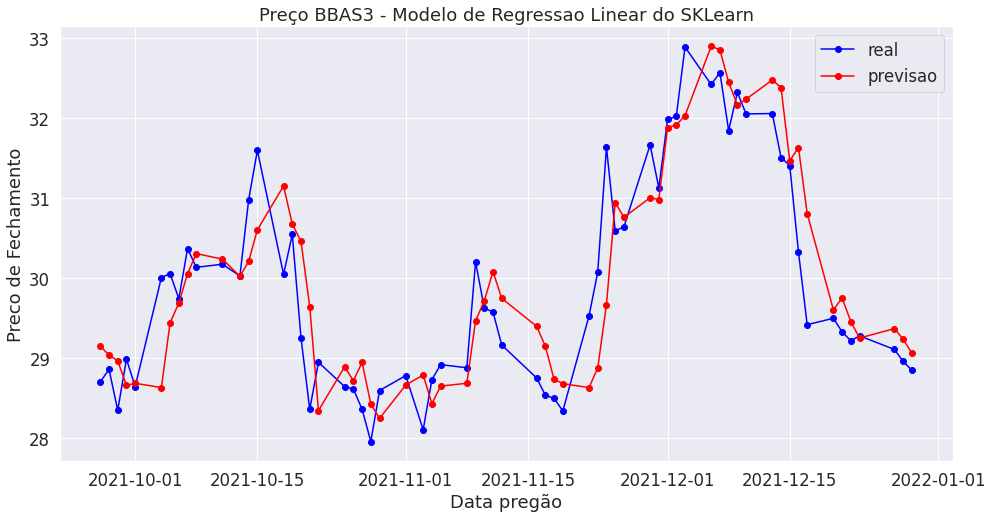

In [ ]:
plt.figure(figsize=(16,8))
plt.title('Preço BBAS3 - Modelo de Regressao Linear do SKLearn')
plt.plot(df_comparativo_lr_vc['real'], label="real", color='blue', marker='o')
plt.plot(df_comparativo_lr_vc['previsao'], label="previsao", color='red', marker='o')
plt.xlabel('Data pregão')
plt.ylabel('Preco de Fechamento')
leg = plt.legend()

## Modelo de Rede Neural MLPRegressor do SKLearn  (com cross-validation)

Multi-layer Perceptron (MLP) is a supervised learning algorithm

In [ ]:
#rede neural
rn = MLPRegressor(max_iter=2000)
rn.fit(x_train_scale, y_train)
pred = rn.predict(x_test_scale)
cd = rn.score(x_test_scale, y_test) #acuracia 

print("score: %.3f%%" % (cd * 100.0))


score: 97.203%


In [ ]:
pred_rn = rn.predict(x_validacao_scale)                     

In [ ]:
#Dataframe comparativo com os dados reais X dados previstos pelo modelo

data_pregao_full = df_bb['data_pregao']
data_pregao=data_pregao_full.tail(64)
res_full=df_bb['preco_fechamento']
res =res_full.tail(64)
df_comparativo =pd.DataFrame({'data_pregao':data_pregao, 'real':res, 'previsao':pred_rn})
df_comparativo.set_index('data_pregao', inplace=True)
df_comparativo['distancia']=   abs(df_comparativo['real'] - df_comparativo['previsao'] )

print(df_comparativo)

                  real   previsao  distancia
data_pregao                                 
2021-09-27   28.704554  29.162879   0.458325
2021-09-28   28.861516  29.059996   0.198480
2021-09-29   28.351388  28.860694   0.509306
2021-09-30   28.989049  28.641054   0.347995
2021-10-01   28.645693  28.614012   0.031681
...                ...        ...        ...
2021-12-22   29.220000  29.352752   0.132752
2021-12-23   29.280000  29.063598   0.216402
2021-12-27   29.110000  28.790935   0.319065
2021-12-28   28.960000  29.102865   0.142865
2021-12-29   28.850000  28.923433   0.073433

[64 rows x 3 columns]


**Validacao Cruzada** 



In [ ]:
#definindo os dados de entreada e saida 

x_entradas = df_bb.loc[:,['preco_maximo','preco_minimo','volume_negocios','qtd_negocios']]
y_target = df_bb.loc[:,['preco_fechamento']]

scaler = MinMaxScaler()

x = scaler.fit_transform(x_entradas) 
y = y_target.to_numpy()

y = np.reshape(y, (3193,)) 


In [ ]:
# construcao da maquina preditiva

num_folds = 4 
seed = 7 
kfold = KFold(num_folds, shuffle=True, random_state= seed)


model_rn_vc = MLPRegressor(max_iter=2000)
acuracia = cross_val_score(model_rn_vc, x, y, cv = kfold)


print("score: %.3f%%" % (acuracia.mean() * 100.0))


score: 99.586%


In [ ]:
#obtendo as predicoes 
new_pred_rn_vc = cross_val_predict(model_rn_vc, x, y, cv=kfold)
new_pred_rn_vc= new_pred_rn_vc[-64:]

In [ ]:
data_pregao_full = df_bb['data_pregao']
data_pregao=data_pregao_full.tail(64)
res_full=df_bb['preco_fechamento']
res=res_full.tail(64)
df_comparativo_rn =pd.DataFrame({'data_pregao':data_pregao, 'real':res, 'previsao':new_pred_rn_vc})
df_comparativo_rn.set_index('data_pregao', inplace=True)
df_comparativo_rn['distancia']=  abs(df_comparativo_rn['real'] - df_comparativo_rn['previsao'] )


print(df_comparativo_rn)

                  real   previsao  distancia
data_pregao                                 
2021-09-27   28.704554  29.085071   0.380517
2021-09-28   28.861516  29.003855   0.142339
2021-09-29   28.351388  28.854315   0.502927
2021-09-30   28.989049  28.598904   0.390145
2021-10-01   28.645693  28.604866   0.040827
...                ...        ...        ...
2021-12-22   29.220000  29.322157   0.102157
2021-12-23   29.280000  29.194531   0.085469
2021-12-27   29.110000  29.232401   0.122401
2021-12-28   28.960000  29.100996   0.140996
2021-12-29   28.850000  29.001683   0.151683

[64 rows x 3 columns]


In [ ]:
#root mean squared error (RMSE) - SEM validacao cruzada

rmse_rn = np.sqrt( np.mean(res - pred_rn)**2 )
rmse_rn 

0.029080094476055585

In [ ]:
#root mean squared error (RMSE)  - COM validacao cruzada
 
rmse_rn = np.sqrt( np.mean(res - new_pred_rn_vc)**2 )
rmse_rn 

0.010831627317404169

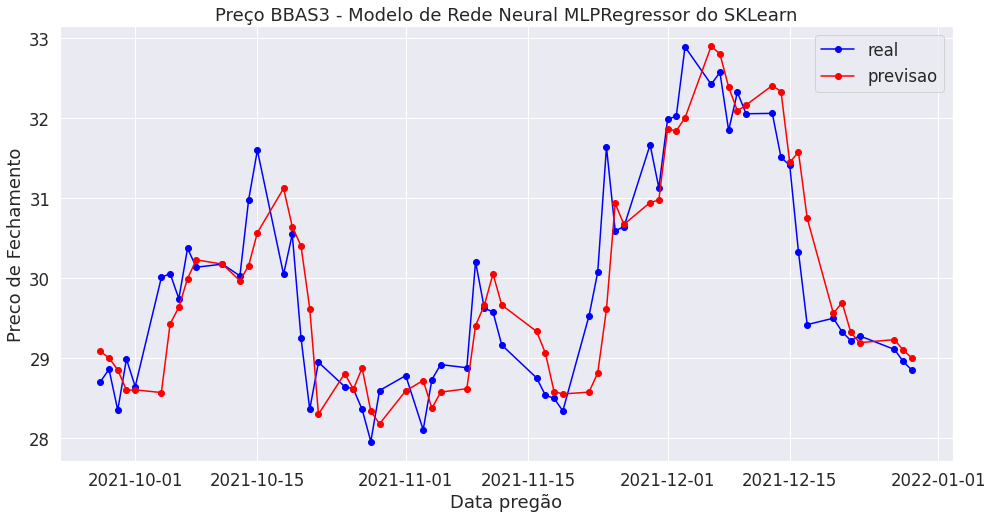

In [ ]:
plt.figure(figsize=(16,8))
plt.title('Preço BBAS3 - Modelo de Rede Neural MLPRegressor do SKLearn')
plt.plot(df_comparativo_rn['real'], label="real", color='blue', marker='o')
plt.plot(df_comparativo_rn['previsao'], label="previsao", color='red', marker='o')
plt.xlabel('Data pregão')
plt.ylabel('Preco de Fechamento')
leg = plt.legend()

## Modelo de Rede Neural LSTM (Long-Short Term Memory )


In [ ]:
df_lstm = df_bb.copy()
df_lstm.set_index('data_pregao', inplace=True)
df_lstm

,sigla_acao,nome_acao,preco_abertura,preco_maximo,preco_minimo,preco_medio,preco_fechamento,qtd_negocios,volume_negocios,mm5d,mm21d
data_pregao,,,,,,,,,,,
2009-01-30,BBAS3,BRASIL ON NM,6.203669,6.372696,6.088626,6.227045,6.036130,2523800,35851049,6.274768,6.430518
2009-02-02,BBAS3,BRASIL ON NM,6.107012,6.261674,5.954287,6.095487,6.220373,2733000,37994527,6.244061,6.404615
2009-02-03,BBAS3,BRASIL ON NM,6.107012,6.381578,5.984621,6.183192,6.123865,2827500,39897234,6.229146,6.381637
2009-02-04,BBAS3,BRASIL ON NM,6.260785,6.461515,6.023623,6.240200,6.316881,4734100,67356685,6.163345,6.336516
2009-02-05,BBAS3,BRASIL ON NM,6.133373,6.425987,6.027957,6.235815,6.395842,3308800,47067643,6.185279,6.308107
...,...,...,...,...,...,...,...,...,...,...,...
2021-12-22,BBAS3,BRASIL ON NM,29.600000,29.650000,29.160000,29.280000,29.220000,12478200,365442015,29.998000,31.306042
2021-12-23,BBAS3,BRASIL ON NM,29.300000,29.480000,29.160000,29.260000,29.280000,7337800,214724088,29.560000,31.265289
2021-12-27,BBAS3,BRASIL ON NM,29.250000,29.490000,29.200000,29.300000,29.110000,5746200,168380059,29.350000,31.153038


In [ ]:
#defininda a quantidade para dados de treinamento 
data = df_lstm.filter(['preco_fechamento'])
dataset = data.values 
training_data_len = math.ceil( len(dataset) * .7 )
training_data_len

2236

In [ ]:
#normalizacao 
scaler2 = MinMaxScaler(feature_range=(0,1))
scaled_data= scaler2.fit_transform(dataset)
scaled_data

array([[0.00378829],
       [0.00816211],
       [0.00587107],
       ...,
       [0.55154847],
       [0.54798755],
       [0.54537622]])

In [ ]:
#criando o dataset de treinamento 
train_data_lstm =scaled_data[0:training_data_len, :]

#spliting os dados em x_train e y_train 
x_train_lstm =[]
y_train_lstm =[] 

for i in range(64, len(train_data_lstm)):
  x_train_lstm.append(train_data_lstm[i-64:i,0])
  y_train_lstm.append(train_data_lstm[i,0])
  if i<=64:
    print(x_train_lstm)
    print(y_train_lstm)
    print()

[array([0.00378829, 0.00816211, 0.00587107, 0.01045315, 0.01232764,
       0.00941175, 0.00774555, 0.00972419, 0.00576692, 0.00868279,
       0.00774555, 0.00264277, 0.00118483, 0.00420484, 0.00575061,
       0.00851944, 0.00969086, 0.00798698, 0.        , 0.00191686,
       0.00798698, 0.00223635, 0.00500517, 0.00372725, 0.00990385,
       0.01096877, 0.01277916, 0.01586747, 0.01544149, 0.02002068,
       0.02566482, 0.02875313, 0.02555833, 0.03727257, 0.03247697,
       0.03269221, 0.03839627, 0.0434546 , 0.04022587, 0.04205549,
       0.05163399, 0.05669231, 0.06605559, 0.06497936, 0.0637955 ,
       0.04722142, 0.04194786, 0.04227073, 0.0448537 , 0.04883578,
       0.05798381, 0.05862954, 0.05421698, 0.0520645 , 0.06088965,
       0.06067441, 0.05550845, 0.05809142, 0.06605559, 0.05916767,
       0.06863855, 0.07089867, 0.08714986, 0.07574174])]
[0.07929332604090158]



In [ ]:
#converter o x_train e o y_train em um numpy array
x_train_lstm, y_train_lstm = np.array(x_train_lstm), np.array(y_train_lstm)

In [ ]:
#reshape os dados
x_train_lstm = np.reshape(x_train_lstm, (x_train_lstm.shape[0], x_train_lstm.shape[1],1)) #64, 1
x_train_lstm.shape

(2172, 64, 1)

In [ ]:
#criando dataset de teste 
test_data = scaled_data[training_data_len - 64: , :]

#spliting os dados em x_test e y_test 
x_test_lstm =  [] 
y_test_lstm = dataset[training_data_len: , :]

for i in range(64, len(test_data)):
  x_test_lstm.append(test_data[i-64:i,0])


In [ ]:
#converter o x_train e o y_train em um numpy array
x_test_lstm = np.array(x_test_lstm)

In [ ]:
#reshape os dados
x_test_lstm = np.reshape(x_test_lstm, (x_test_lstm.shape[0], x_test_lstm.shape[1],1)) 
x_test_lstm.shape

(957, 64, 1)

In [ ]:
#Criando o Modelo LSTM

lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape =(x_train_lstm.shape[1],1))) #64, 1
lstm_model.add(LSTM(50, return_sequences=False))
lstm_model.add(Dense(25))
lstm_model.add(Dense(1))


In [ ]:
#Compilando o modelo

lstm_model.compile(optimizer='adam', loss='mean_squared_error') 

In [ ]:
#treinamento do modelo LSTM

lstm_model.fit(x_train_lstm, y_train_lstm, batch_size=1, epochs=1)

2172/2172 [==============================] - 67s 29ms/step - loss: 9.4673e-04


In [ ]:
#previsoes 
pred_lstm = lstm_model.predict(x_test_lstm)
pred_lstm = scaler2.inverse_transform(pred_lstm)


In [ ]:
#data frame comparativo do dados reais X dados previstos pelo modelo
data_pregao_full = df_bb['data_pregao']
data_pregao=data_pregao_full.tail(64)
data_df_lstm_full =pd.Series( df_lstm['preco_fechamento'].values )
data_df_lstm =data_df_lstm_full.tail(64)
res_lstm_full=  pred_lstm 
ress_lstm = res_lstm_full[-64:] #.tail(64)
data_df_lstm_series = pd.Series(data_df_lstm)

df_comparativo_lstm =pd.DataFrame({'data_pregao':data_pregao, 'real':data_df_lstm}) #, 'previsao':data_pregao})
df_comparativo_lstm['previsao'] = ress_lstm
df_comparativo_lstm.set_index('data_pregao', inplace=True)

df_comparativo_lstm['distancia']= abs(df_comparativo_lstm['real'] - df_comparativo_lstm['previsao'])


print(df_comparativo_lstm)

                  real   previsao  distancia
data_pregao                                 
2021-09-27   28.704554  29.279980   0.575426
2021-09-28   28.861516  29.352924   0.491408
2021-09-29   28.351388  29.391056   1.039668
2021-09-30   28.989049  29.292456   0.303407
2021-10-01   28.645693  29.295248   0.649555
...                ...        ...        ...
2021-12-22   29.220000  30.387880   1.167880
2021-12-23   29.280000  30.079329   0.799329
2021-12-27   29.110000  29.901403   0.791403
2021-12-28   28.960000  29.784103   0.824103
2021-12-29   28.850000  29.690437   0.840437

[64 rows x 3 columns]


In [ ]:
#root mean squared error (RMSE)

rmse_lstm = np.sqrt( np.mean(pred_lstm - y_test_lstm)**2 )
rmse_lstm 

0.6791622593860208

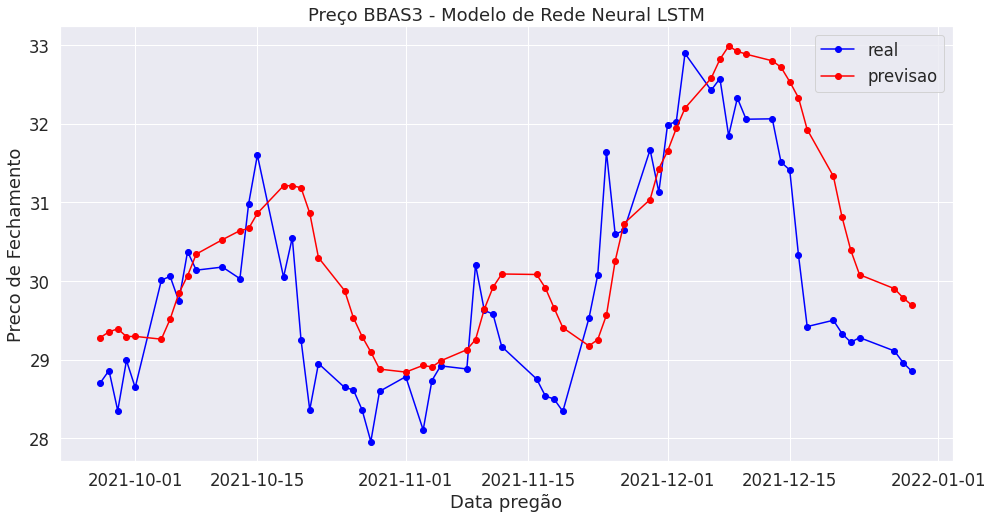

In [ ]:
plt.figure(figsize=(16,8))
plt.title('Preço BBAS3 - Modelo de Rede Neural LSTM')
plt.plot(df_comparativo_lstm['real'], label="real", color='blue', marker='o')
plt.plot(df_comparativo_lstm['previsao'], label="previsao", color='red', marker='o')
plt.xlabel('Data pregão')
plt.ylabel('Preco de Fechamento')
leg = plt.legend()

## Comparação dos modelos


In [ ]:
#dataframe comparativo 
comparacao_3_modelos = pd.DataFrame()
comparacao_3_modelos['real'] = df_comparativo_lr_vc['real']
comparacao_3_modelos['previsao_regressao_linear'] = df_comparativo_lr_vc['previsao']
comparacao_3_modelos['previsao_rede_neural'] = df_comparativo_rn['previsao']
comparacao_3_modelos['previsao_lstm'] = df_comparativo_lstm['previsao']
comparacao_3_modelos = comparacao_3_modelos.loc[:,['real','previsao_regressao_linear','previsao_rede_neural','previsao_lstm']]


In [ ]:
comparacao_3_modelos

,real,previsao_regressao_linear,previsao_rede_neural,previsao_lstm
data_pregao,,,,
2021-09-27,28.704554,29.150533,29.085071,29.279980
2021-09-28,28.861516,29.041620,29.003855,29.352924
2021-09-29,28.351388,28.966946,28.854315,29.391056
2021-09-30,28.989049,28.660971,28.598904,29.292456
2021-10-01,28.645693,28.687569,28.604866,29.295248
...,...,...,...,...
2021-12-22,29.220000,29.458440,29.322157,30.387880
2021-12-23,29.280000,29.253242,29.194531,30.079329
2021-12-27,29.110000,29.370990,29.232401,29.901403


In [ ]:
print("RMSE modelo Regressao Linear        : %.4f" % rmse_lr)
print("RMSE modelo Rede Neural Multicamada : %.4f" % rmse_rn)
print("RMSE modelo Rede Neural LSTM        : %.4f"  % rmse_lstm)


RMSE modelo Regressao Linear        : 0.0750
RMSE modelo Rede Neural Multicamada : 0.0108
RMSE modelo Rede Neural LSTM        : 0.6792


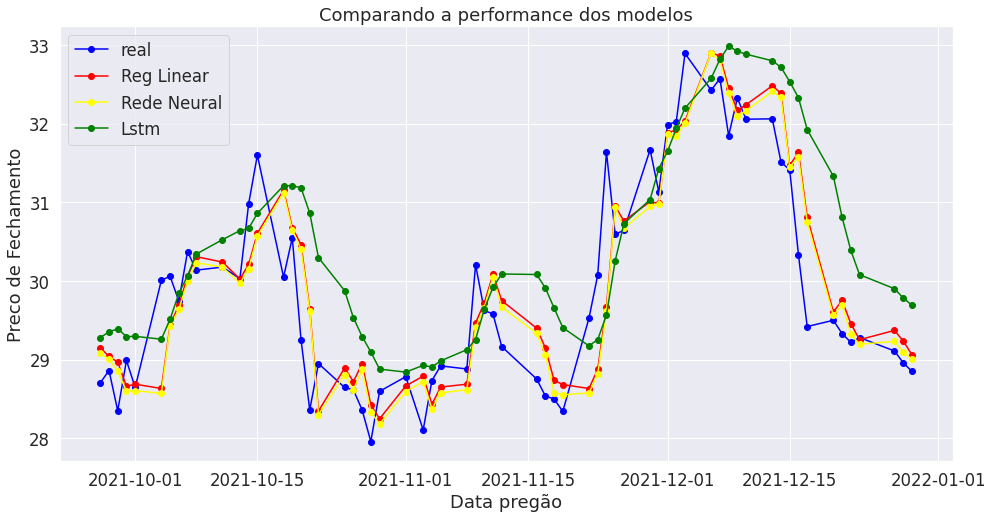

In [ ]:
plt.figure(figsize=(16,8))
plt.title('Comparando a performance dos modelos')
plt.plot(comparacao_3_modelos['real'], label="real", color='blue', marker='o')
plt.plot(comparacao_3_modelos['previsao_regressao_linear'], label="Reg Linear", color='red', marker='o')
plt.plot(comparacao_3_modelos['previsao_rede_neural'], label="Rede Neural", color='yellow', marker='o')
plt.plot(comparacao_3_modelos['previsao_lstm'], label="Lstm", color='green', marker='o')
plt.xlabel('Data pregão')
plt.ylabel('Preco de Fechamento')
leg = plt.legend()